In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [39]:

!git init

Reinitialized existing Git repository in /content/.git/


In [40]:
!git clone -b colab-branch https://github.com/Qbbz/SSP.git

fatal: destination path 'SSP' already exists and is not an empty directory.


In [ ]:
!git pull https://github.com/Qbbz/SSP.git colab-branch

In [ ]:
!pip install -r requirements.txt

In [54]:
import copy
import inspect
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

from grakn.client import GraknClient
from KGCN.pipeline_mod import pipeline
#from kglib.kgcn.pipeline.pipeline import pipeline
from kglib.utils.graph.iterate import multidigraph_data_iterator
from kglib.utils.graph.query.query_graph import QueryGraph
from kglib.utils.grakn.type.type import get_thing_types, get_role_types
#from kglib.utils.graph.thing.queries_to_graph import build_graph_from_queries
from kglib.utils.graph.thing.queries_to_graph import combine_2_graphs, combine_n_graphs, concept_dict_from_concept_map
from kglib.utils.grakn.object.thing import build_thing
from kglib.utils.graph.thing.concept_dict_to_graph import concept_dict_to_graph
from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
### Test tf for GPU acceleration
# TODO: Issues with GPU acceleration
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.reset_default_graph() #fix bugs with tensor of uknonw size
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation) #filter out mpl warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN) #filter out annoying messages about name format with ':'
import os
import sys
from pathlib import Path
from mylib.data_prep import LoadData, FeatDuct, UndersampleData


Tensorflow version 1.14.0
Num GPUs Available:  1


In [56]:
PATH = os.getcwd() #+'\data\\'
#sys.path.insert(1, PATH + '/mylib/')
#print(PATH)
DATAPATH = Path(PATH+"/data/")
ALLDATA = LoadData(DATAPATH)
ALLDATA = FeatDuct(ALLDATA, Input_Only = True) #leave only model input
PROCESSED_DATA = pd.read_csv(str(DATAPATH)+"/ducts_data.csv")

KEYSPACE =  "kgcn_schema_full" #"kgcn500n2500" #"ssp_schema_slope0"  #"sampled_ssp_schema_kgcn"
URI = "localhost:48555"
SAVEPATH = str(DATAPATH) + "/nx_500n2500/" #nx_500n2500

# Existing elements in the graph are those that pre-exist in the graph, and should be predicted to continue to exist
PREEXISTS = 0
# Candidates are neither present in the input nor in the solution, they are negative samples
CANDIDATE = 1
# Elements to infer are the graph elements whose existence we want to predict to be true, they are positive samples
TO_INFER = 2

# Categorical Attribute types and the values of their categories
ses = ['Winter', 'Spring', 'Summer', 'Autumn']
locations = []
for ssp in ALLDATA['profile']:
    season = next((s for s in ses if s in ssp), False)
    location = ssp.replace(season, '')[:-1]
    location = location.replace(' ', '-')
    locations.append(location)
loc = np.unique(locations).tolist()

# Categorical Attributes and lists of their values
CATEGORICAL_ATTRIBUTES = {'season': ses,
                          'location': loc}
                          #duct_type': ["NotDuct","SLD","DC"]}
# Continuous Attribute types and their min and max values
"""
CONTINUOUS_ATTRIBUTES = {'depth': (0, 1500), 
                         'num_rays': (500, 15000), 
                         'slope': (-2, 2), 
                         'bottom_type': (1,2),
                         'length': (0, 44000),
                         'SSP_value':(1463.486641,1539.630391),
                         'grad': (-0.290954924,0.040374179),
                         'number_of_ducts': (1,2)}
"""
CONTINUOUS_ATTRIBUTES = {'depth': (0, 1200), 
                         'num_rays': (500, 2500), 
                         'slope': (-2, 2), 
                         'bottom_type': (1,2),
                         'length': (0, 44000),
                         'SSP_value':(1463.486641,1539.630391),
                         'grad': (-0.290954924,0.040374179),
                         'number_of_ducts': (1,2)}

TYPES_TO_IGNORE = ['candidate-convergence', 'scenario_id', 'probability_exists', 'probability_nonexists', 'probability_preexists']
ROLES_TO_IGNORE = ['candidate_resolution', 'candidate_scenario']

# The learner should see candidate relations the same as the ground truth relations, so adjust these candidates to
# look like their ground truth counterparts

TYPES_AND_ROLES_TO_OBFUSCATE = {'candidate-convergence': 'convergence',
                                'candidate_resolution': 'minimum_resolution',
                                'candidate_scenario': 'converged_scenario'}

In [16]:
def build_graph_from_queries(query_sampler_variable_graph_tuples, grakn_transaction,
                             concept_dict_converter=concept_dict_to_graph, infer=True):
    """
    Builds a graph of Things, interconnected by roles (and *has*), from a set of queries and graphs representing those
    queries (variable graphs)of those queries, over a Grakn transaction

    Args:
        infer: whether to use Grakn's inference engine
        query_sampler_variable_graph_tuples: A list of tuples, each tuple containing a query, a sampling function,
            and a variable_graph
        grakn_transaction: A Grakn transaction
        concept_dict_converter: The function to use to convert from concept_dicts to a Grakn model. This could be
            a typical model or a mathematical model

    Returns:
        A networkx graph
    """
    query_concept_graphs = []

    for query, sampler, variable_graph in query_sampler_variable_graph_tuples:

        concept_maps = sampler(grakn_transaction.query(query, infer=infer))
        concept_dicts = [concept_dict_from_concept_map(concept_map) for concept_map in concept_maps]
        #TODO: Implement removal of NotDuct cases at NetworkX level instead of query workaround
        """
        #print(concept_dicts)
        notaduct = 0
        for cd in concept_dicts:
            print(cd)
            for variable, thing in cd.items(): #key, value
                if variable == 'gd' and thing.value == 0.0:#and '0.0' in value:
                    print(variable, thing.value)
                    #cd.pop('gd')
                    #cd.pop('dct')
                    #cd.pop('SSP-channel')
                    #cd.pop()
                    #val = 'grad' in cd['gd']
                    #print(val)
                    #if '0.0' in value:
                    #    print('asdasda')
        """
        answer_concept_graphs = []
        for concept_dict in concept_dicts:
            try:
                answer_concept_graphs.append(concept_dict_converter(concept_dict, variable_graph))
            except ValueError as e:
                raise ValueError(str(e) + f'Encountered processing query:\n \"{query}\"')

        if len(answer_concept_graphs) > 1:
            query_concept_graph = combine_n_graphs(answer_concept_graphs)
            query_concept_graphs.append(query_concept_graph)
        else:
            if len(answer_concept_graphs) > 0:
                query_concept_graphs.append(answer_concept_graphs[0])
            else:
                warnings.warn(f'There were no results for query: \n\"{query}\"\nand so nothing will be added to the '
                              f'graph for this query')

    if len(query_concept_graphs) == 0:
        # Raise exception when none of the queries returned any results
        raise RuntimeError(f'The graph from queries: {[query_sampler_variable_graph_tuple[0] for query_sampler_variable_graph_tuple in query_sampler_variable_graph_tuples]}\n'
                           f'could not be created, since none of these queries returned results')

    concept_graph = combine_n_graphs(query_concept_graphs)
    #TODO: Remove NotDuct result from NetworkX graph completely: entity duct, attr grad 0, depth 0
     
    
    return concept_graph

def create_concept_graphs(example_indices, grakn_session, savepath):
    """
    Builds an in-memory graph for each example, with an scenario_id as an anchor for each example subgraph.
    Args:
        example_indices: The values used to anchor the subgraph queries within the entire knowledge graph
        =>> SCENARIO_ID
        grakn_session: Grakn Session

    Returns:
        In-memory graphs of Grakn subgraphs
        
    Outline:    
    For scnenario_id with open grakn session:
        0. check if the nx.graph for example doesn't exists already in the output directory
        if yes: load nx.graph from pickle file
        if no: 
            1. get_query_handles()
            2. build_graph_from_queries()
            3. obfuscate_labels() whatever it means
            4. graph.name = scenario_idx
            5. save ns.graph as pickle file
            6. append graph to list of graphs and return the list as func. output
            

    """
    
    graphs = []
    infer = True
    total = len(example_indices)
    # finds scenarios idx without ducts
    not_duct_idx = []
    for idx, sld, dc in zip(range(len(PROCESSED_DATA)),PROCESSED_DATA['SLD_depth'],PROCESSED_DATA['DC_axis']):
        if np.isnan(sld) and np.isnan(dc):
            not_duct_idx.append(idx)
        
    for it, scenario_idx in enumerate(example_indices):
        graph_filename = f'graph_{scenario_idx}.gpickle'
        if not os.path.exists(str(savepath)+"/"+graph_filename):
            print(f'[{it+1}|{total}] Creating graph for example {scenario_idx}')
            graph_query_handles = get_query_handles(scenario_idx, not_duct_idx)
            #print(graph_query_handles)
            with grakn_session.transaction().read() as tx:
                # Build a graph from the queries, samplers, and query graphs
                graph = build_graph_from_queries(graph_query_handles, tx, infer=infer)
    
            obfuscate_labels(graph, TYPES_AND_ROLES_TO_OBFUSCATE)
    
            graph.name = scenario_idx
            nx.write_gpickle(graph, savepath+graph_filename)
        
        else:
            print(f'[{it+1}|{total}] NetworkX graph loaded {graph_filename}')
            graph = nx.read_gpickle(savepath+graph_filename)    
        
        graphs.append(graph)

        #TODO: SWITCH plot NetworkX graphs 
        #new_graph = nx.Graph(graph)
        #nx.draw(new_graph, with_labels=True)
        #plt.show()
    return graphs

def obfuscate_labels(graph, types_and_roles_to_obfuscate):
    # Remove label leakage - change type labels that indicate candidates into non-candidates
    for data in multidigraph_data_iterator(graph):
        for label_to_obfuscate, with_label in types_and_roles_to_obfuscate.items():
            if data['type'] == label_to_obfuscate:
                data.update(type=with_label)
                break

def get_query_handles(scenario_idx, not_duct_idx):
        
    """
    Creates an iterable, each element containing a Graql query, a function to sample the answers, and a QueryGraph
    object which must be the Grakn graph representation of the query. This tuple is termed a "query_handle"
    Args:
        scenario_idx: A uniquely identifiable attribute value used to anchor the results of the queries to a specific subgraph
    Returns:
        query handles
    """
    # === Query variables ===
    conv, scn, ray, nray, src, dsrc, seg, dseg, l, s, srcp, bathy, bt, ssp, loc, ses,\
    sspval, dsspmax, speed, dssp, dct, ddct, gd, duct, nod = 'conv','scn','ray', 'nray',\
    'src', 'dsrc', 'seg', 'dseg','l','s','srcp','bathy','bt','ssp','loc','ses',\
    'sspval','dsspmax','speed','dssp','dct','ddct','gd','duct','nod'
    # dt, 'dt'
    
    
    # === Candidate Convergence ===
    candidate_convergence_query = inspect.cleandoc(f'''match
           $scn isa sound-propagation-scenario, has scenario_id {scenario_idx};'''
           '''$ray isa ray-input, has num_rays $nray;
           $conv(candidate_scenario: $scn, candidate_resolution: $ray) isa candidate-convergence; 
           get;''')    
 
    candidate_convergence_query_graph = (QueryGraph()
                                       .add_vars([conv], CANDIDATE)
                                       .add_vars([scn, ray, nray], PREEXISTS)
                                       .add_has_edge(ray, nray, PREEXISTS)
                                       .add_role_edge(conv, scn, 'candidate_scenario', CANDIDATE)
                                       .add_role_edge(conv, ray, 'candidate_resolution', CANDIDATE))

    
    if scenario_idx not in not_duct_idx:
        # === Convergence: SCN with ducts ===    
        convergence_query_full = inspect.cleandoc(
            f'''match 
            $scn isa sound-propagation-scenario, has scenario_id {scenario_idx};'''
            '''$ray isa ray-input, has num_rays $nray; 
            $src isa source, has depth $dsrc; 
            $seg isa bottom-segment, has depth $dseg, has length $l, has slope $s;
            $conv(converged_scenario: $scn, minimum_resolution: $ray) isa convergence;
            $srcp(defined_by_src: $scn, define_src: $src) isa src-position;
            $bathy(defined_by_bathy: $scn, define_bathy: $seg) isa bathymetry, has bottom_type $bt;
            $ssp isa SSP-vec, has location $loc, has season $ses, has SSP_value $sspval, has depth $dsspmax;
            $dct isa duct, has depth $ddct, has grad $gd;
            $speed(defined_by_SSP: $scn, define_SSP: $ssp) isa sound-speed;
            $duct(find_channel: $ssp, channel_exists: $dct) isa SSP-channel, has number_of_ducts $nod;
            $sspval has depth $dssp;
            {$dssp == $dsrc;} or {$dssp == $dseg;} or {$dssp == $ddct;} or {$dssp == $dsspmax;}; 
            get;'''
            )
        # has duct_type $dt,
        
        convergence_query_full_graph = (QueryGraph()
                                 .add_vars([conv], TO_INFER)
                                 .add_vars([scn, ray, nray, src, dsrc, seg, dseg, \
                                            l, s, srcp, bathy, bt, ssp, loc, ses, \
                                            sspval, dsspmax, speed, dssp, dct, ddct,\
                                            gd, duct, nod], PREEXISTS) #dt
                                 .add_has_edge(ray, nray, PREEXISTS)
                                 .add_has_edge(src, dsrc, PREEXISTS)
                                 .add_has_edge(seg, dseg, PREEXISTS)
                                 .add_has_edge(seg, l, PREEXISTS)
                                 .add_has_edge(seg, s, PREEXISTS)
                                 .add_has_edge(ssp, loc, PREEXISTS)
                                 .add_has_edge(ssp, ses, PREEXISTS)
                                 .add_has_edge(ssp, sspval, PREEXISTS)
                                 .add_has_edge(ssp, dsspmax, PREEXISTS)
                                 .add_has_edge(dct, ddct, PREEXISTS)
                                 #.add_has_edge(dct, dt, PREEXISTS)
                                 .add_has_edge(dct, gd, PREEXISTS)
                                 .add_has_edge(bathy, bt, PREEXISTS)
                                 .add_has_edge(duct, nod, PREEXISTS)
                                 .add_has_edge(sspval, dssp, PREEXISTS)
                                 .add_role_edge(conv, scn, 'converged_scenario', TO_INFER) #TO_INFER VS CANDIDATE BELOW
                                 .add_role_edge(conv, ray, 'minimum_resolution', TO_INFER)
                                 .add_role_edge(srcp, scn, 'defined_by_src', PREEXISTS)
                                 .add_role_edge(srcp, src, 'define_src', PREEXISTS)
                                 .add_role_edge(bathy, scn, 'defined_by_bathy', PREEXISTS)
                                 .add_role_edge(bathy, seg, 'define_bathy', PREEXISTS)
                                 .add_role_edge(speed, scn, 'defined_by_SSP', PREEXISTS)
                                 .add_role_edge(speed, ssp, 'define_SSP', PREEXISTS)
                                 .add_role_edge(duct, ssp, 'find_channel', PREEXISTS)
                                 .add_role_edge(duct, dct, 'channel_exists', PREEXISTS)
                                 )
        return [
            (convergence_query_full, lambda x: x, convergence_query_full_graph),
            (candidate_convergence_query, lambda x: x, candidate_convergence_query_graph)
            ]
    
    
    else:        
        # === Convergence: SCN with\without ducts ===
        convergence_query_reduced = inspect.cleandoc(
                f'''match 
                $scn isa sound-propagation-scenario, has scenario_id {scenario_idx};'''
                '''$ray isa ray-input, has num_rays $nray; 
                $src isa source, has depth $dsrc; 
                $seg isa bottom-segment, has depth $dseg, has length $l, has slope $s;
                $conv(converged_scenario: $scn, minimum_resolution: $ray) isa convergence;
                $srcp(defined_by_src: $scn, define_src: $src) isa src-position;
                $bathy(defined_by_bathy: $scn, define_bathy: $seg) isa bathymetry, has bottom_type $bt;
                $ssp isa SSP-vec, has location $loc, has season $ses, has SSP_value $sspval, has depth $dsspmax;
                $speed(defined_by_SSP: $scn, define_SSP: $ssp) isa sound-speed;
                $sspval has depth $dssp;
                {$dssp == $dsrc;} or {$dssp == $dseg;} or {$dssp == $dsspmax;}; 
                get;'''
                )
            
        convergence_query_reduced_graph = (QueryGraph()
                                 .add_vars([conv], TO_INFER)
                                 .add_vars([scn, ray, nray, src, dsrc, seg, dseg, \
                                            l, s, srcp, bathy, bt, ssp, loc, ses, \
                                            sspval, dsspmax, speed, dssp], PREEXISTS)
                                 .add_has_edge(ray, nray, PREEXISTS)
                                 .add_has_edge(src, dsrc, PREEXISTS)
                                 .add_has_edge(seg, dseg, PREEXISTS)
                                 .add_has_edge(seg, l, PREEXISTS)
                                 .add_has_edge(seg, s, PREEXISTS)
                                 .add_has_edge(ssp, loc, PREEXISTS)
                                 .add_has_edge(ssp, ses, PREEXISTS)
                                 .add_has_edge(ssp, sspval, PREEXISTS)
                                 .add_has_edge(ssp, dsspmax, PREEXISTS)
                                 .add_has_edge(bathy, bt, PREEXISTS)                           
                                 .add_has_edge(sspval, dssp, PREEXISTS)
                                 .add_role_edge(conv, scn, 'converged_scenario', TO_INFER) #TO_INFER VS CANDIDATE BELOW
                                 .add_role_edge(conv, ray, 'minimum_resolution', TO_INFER)
                                 .add_role_edge(srcp, scn, 'defined_by_src', PREEXISTS)
                                 .add_role_edge(srcp, src, 'define_src', PREEXISTS)
                                 .add_role_edge(bathy, scn, 'defined_by_bathy', PREEXISTS)
                                 .add_role_edge(bathy, seg, 'define_bathy', PREEXISTS)
                                 .add_role_edge(speed, scn, 'defined_by_SSP', PREEXISTS)
                                 .add_role_edge(speed, ssp, 'define_SSP', PREEXISTS)
                                 )    
            

        return [
            (convergence_query_reduced, lambda x: x, convergence_query_reduced_graph),
            (candidate_convergence_query, lambda x: x, candidate_convergence_query_graph)
            ]

def write_predictions_to_grakn(graphs, tx, commit = True):
    """
    Take predictions from the ML model, and insert representations of those predictions back into the graph.

    Args:
        graphs: graphs containing the concepts, with their class predictions and class probabilities
        tx: Grakn write transaction to use

    Returns: None

    """
    
    #TODO: Revise these loops and see why nothing is being predicted as data['prediction']=2 (exists?)
    for graph in graphs:
        for node, data in graph.nodes(data=True):
            if data['prediction'] == 2:
                concept = data['concept']
                concept_type = concept.type_label
                if concept_type == 'convergence' or concept_type == 'candidate-convergence':
                    neighbours = graph.neighbors(node)

                    for neighbour in neighbours:
                        concept = graph.nodes[neighbour]['concept']
                        if concept.type_label == 'sound-propagation-scenario':
                            scenario = concept
                        else:
                            ray = concept

                    p = data['probabilities']
                    query = (f'match '
                             f'$scn id {scenario.id}; '
                             f'$ray id {ray.id}; '
                             f'insert '
                             f'$conv(converged_scenario: $scn, minimum_resolution: $ray) isa convergence, '
                             f'has probability_exists {p[2]:.3f}, '
                             f'has probability_nonexists {p[1]:.3f}, '  
                             f'has probability_preexists {p[0]:.3f};')
                    print(query)
                    tx.query(query)
    if commit:
        tx.commit()

import re
def ubuntu_rand_fix(savepath):
    #savepath = PATH + '/networkx/'
    graphfiles = [f for f in os.listdir(savepath) if os.path.isfile(os.path.join(savepath, f))]
    example_idx = []
    for gfile in graphfiles:
        idx = re.findall(r'\d+', gfile)[0]    
        example_idx.append(idx)
    return example_idx



In [57]:
def prepare_data(session, data, train_split, validation_split, savepath, ubuntu_fix = True):
    """
    Args:
        data: full dataset with sorted scenario_id's that will be used for querying grakn
        train_split: size of the training set; 
        validaton_split: size of the validaton set subtracted from the test set; 
    
        Test set is further split down into test and validation so that
        test_set size = (1-train_split)*(1-validation_split)
        so i.e. train_split = 0.7, validation_split=0.33 results in:
        70% training set, 20.1% test set, 9.9% validation set
    """
    seed = 123
    
    y = data.pop('num_rays').to_frame()
    X = data
    # divide whole dataset into stratified train\test 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, shuffle = True, random_state = seed, test_size=1-train_split)
    #if validation_split > 0:
    #divide test dataset into stratified test\validation subsets
    #X_test, X_val, y_test, y_val = train_test_split(
    #X_test, y_test, stratify=y_test, shuffle = True, random_state = seed, test_size=validation_split)
    
    training_data = [X_train, y_train]
    testing_data = [X_test, y_test]
    #validation_data = [X_val, y_val]
    
    # data was split and shuffled while mainating original indices 
    # now the training and test set indices are merged once again
    # and will be split again inside the grakn pipeline until tr_ge_split, without shuffle
    
    num_tr_graphs = len(X_test) + len(X_train)   
    #num_val_graphs = len(X_val)
    example_idx_tr = X_train.index.tolist() + X_test.index.tolist() #training and test sets indices merged for training

    # rand in linux and windows generates different number in effect the data selected in windows is different than ubuntu
    if ubuntu_fix:
        example_idx_tr = ubuntu_rand_fix(savepath)
    #example_idx_val = X_val.index.tolist()
    tr_ge_split = int(num_tr_graphs * train_split)  # Define graph number split in train graphs[:tr_ge_split] and test graphs[tr_ge_split:] sets
    #val_ge_split = int(len(X_val)*(1-validation_split))
    print(f'\nCREATING {num_tr_graphs} TRAINING\TEST GRAPHS')
    train_graphs = create_concept_graphs(example_idx_tr, session, savepath)  # Create validation graphs in networkX
    #print(f'\nCREATING {num_val_graphs} VALIDATION GRAPHS')
    #val_graphs = create_concept_graphs(example_idx_val, session, savepath) # Create training graphs in networkX
    
    return  train_graphs, tr_ge_split, training_data, testing_data #, val_graphs,  val_ge_split

def go_train(train_graphs, tr_ge_split, **kwargs):
    """
    Args:
           
    Parameters
    ----------
    train_graphs : networkx graphs obtained from grakn queries - the set contains both train and test graphs!
    tr_ge_split : int. value marking the number of training graphs in train_graphs
    save_fle : model filename to be saved as tf. checkpoin
    **kwargs : TYPE

    Returns:
    ge_graphs: Encoded in-memory graphs of Grakn concepts for generalisation
    solveds_tr: training fraction examples solved correctly
    solveds_ge: test/generalization fraction examples solved correctly

    """
    # Run the pipeline with prepared networkx graph
    #ge_graphs, solveds_tr, solveds_ge, graphs_enc, input_graphs, target_graphs, feed_dict 
    ge_graphs, solveds_tr, solveds_ge = pipeline(graphs = train_graphs,             
                                                tr_ge_split = tr_ge_split,                         
                                                do_test = False,
                                                **kwargs)
    
    training_evals= [solveds_tr, solveds_ge]   
    return ge_graphs, solveds_tr, solveds_ge

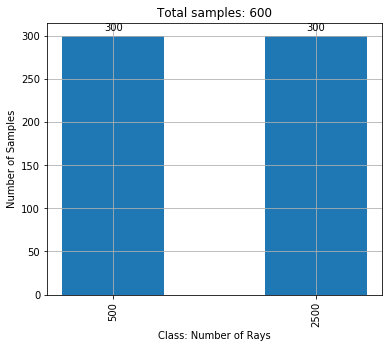

{500: (300, 50.0), 2500: (300, 50.0)}

CREATING 600 TRAINING\TEST GRAPHS
[1|600] NetworkX graph loaded graph_5632.gpickle
[2|600] NetworkX graph loaded graph_813.gpickle
[3|600] NetworkX graph loaded graph_1579.gpickle
[4|600] NetworkX graph loaded graph_6217.gpickle
[5|600] NetworkX graph loaded graph_6460.gpickle
[6|600] NetworkX graph loaded graph_284.gpickle
[7|600] NetworkX graph loaded graph_8735.gpickle
[8|600] NetworkX graph loaded graph_3480.gpickle
[9|600] NetworkX graph loaded graph_8582.gpickle
[10|600] NetworkX graph loaded graph_8815.gpickle
[11|600] NetworkX graph loaded graph_6038.gpickle
[12|600] NetworkX graph loaded graph_4742.gpickle
[13|600] NetworkX graph loaded graph_3042.gpickle
[14|600] NetworkX graph loaded graph_7839.gpickle
[15|600] NetworkX graph loaded graph_7814.gpickle
[16|600] NetworkX graph loaded graph_3200.gpickle
[17|600] NetworkX graph loaded graph_2436.gpickle
[18|600] NetworkX graph loaded graph_422.gpickle
[19|600] NetworkX graph loaded graph_15

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown sha

RoleEmbedder/embed/embeddings:0
RoleEmbedder/layer_norm/gamma:0
RoleEmbedder/layer_norm/beta:0
KGCN/kg_encoder/edge_model/mlp/linear_0/w:0
KGCN/kg_encoder/edge_model/mlp/linear_0/b:0
KGCN/kg_encoder/edge_model/mlp/linear_1/w:0
KGCN/kg_encoder/edge_model/mlp/linear_1/b:0
KGCN/kg_encoder/edge_model/layer_norm/gamma:0
KGCN/kg_encoder/edge_model/layer_norm/beta:0
ThingEmbedder/embed/embeddings:0
ThingEmbedder/layer_norm/gamma:0
ThingEmbedder/layer_norm/beta:0
ThingEmbedder/typewise_encoder/location_cat_embedder/embed/embeddings:0
ThingEmbedder/typewise_encoder/location_cat_embedder_1/embed/embeddings:0
ThingEmbedder/typewise_encoder/number_of_ducts_cat_embedder/mlp/linear_0/w:0
ThingEmbedder/typewise_encoder/number_of_ducts_cat_embedder/mlp/linear_0/b:0
ThingEmbedder/typewise_encoder/number_of_ducts_cat_embedder/mlp/linear_1/w:0
ThingEmbedder/typewise_encoder/number_of_ducts_cat_embedder/mlp/linear_1/b:0
ThingEmbedder/typewise_encoder/number_of_ducts_cat_embedder/mlp/linear_2/w:0
ThingEmbe

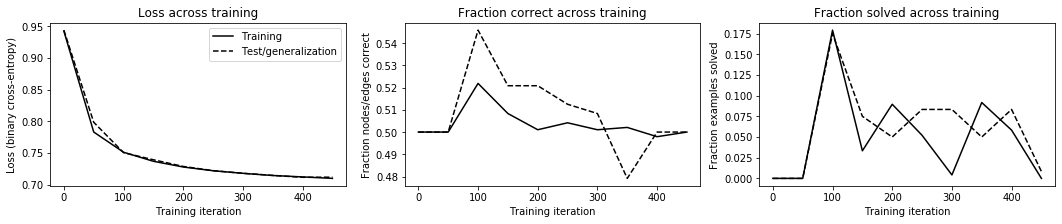

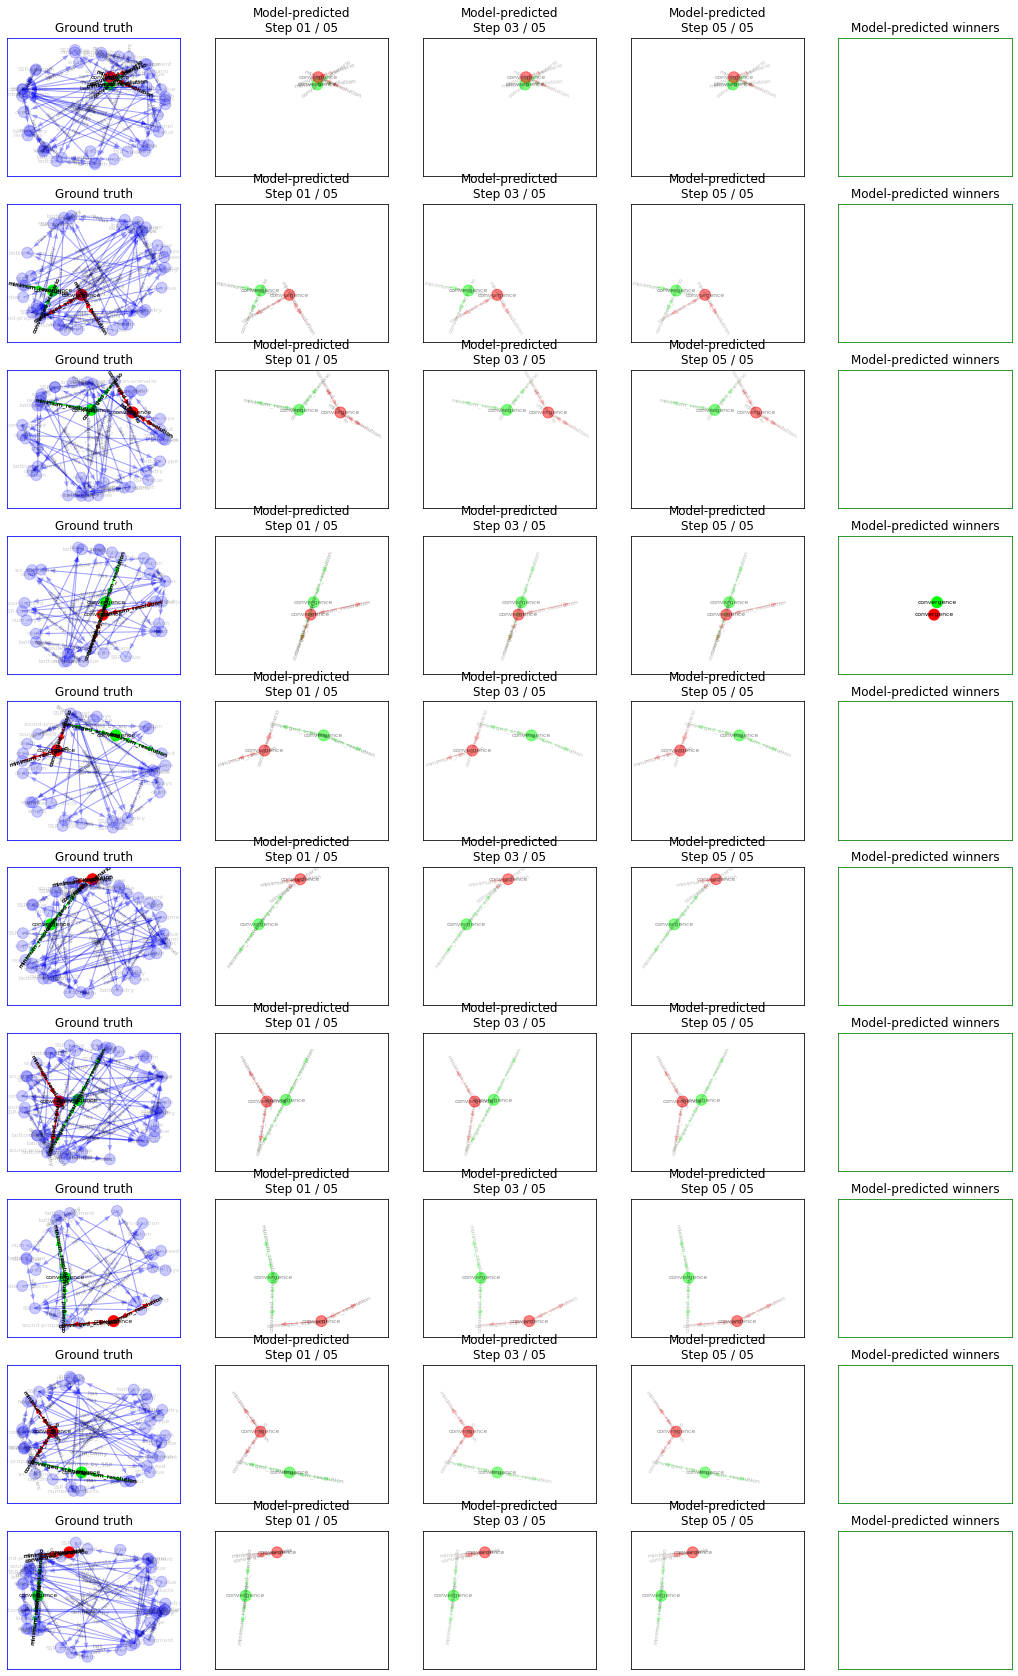

In [59]:
##### RUN THE PIPELINE  #####  

# DATA SELECTION FOR GRAKN TESTING
from data_analysis import ClassImbalance

#data = UndersampleData(ALLDATA, max_sample = 100)
#data = UndersampleData(data, max_sample = 30) #at 30 you got 507 nx graphs created, howeve with NotDuct at this point

# === 2 classes of 2000 sample 500/2500 ==== 
data_sparse2 = ALLDATA[(ALLDATA.loc[:,'num_rays'] == 500) | (ALLDATA.loc[:,'num_rays'] == 2500)]
data = UndersampleData(data_sparse2, max_sample = 300)
#data = data[(data.loc[:,'num_rays']==500) | (data.loc[:31,'num_rays'] == 2500)]
#data = data[:20]


class_population = ClassImbalance(data, plot = True)
plt.show()
print(class_population)

#client = GraknClient(uri=URI)
session = None #client.session(keyspace=KEYSPACE)
"""
with session.transaction().read() as tx:
        # Change the terminology here onwards from thing -> node and role -> edge
        node_types = get_thing_types(tx)
        [node_types.remove(el) for el in TYPES_TO_IGNORE]
        edge_types = get_role_types(tx)
        [edge_types.remove(el) for el in ROLES_TO_IGNORE]
        print(f'Found node types: {node_types}')
        print(f'Found edge types: {edge_types}')
"""
node_types = ['SSP-vec', 'bottom-segment', 'duct', 'ray-input', 'source', 'sound-propagation-scenario', 'SSP_value', 'depth', 'location', 'season', 'grad', 'num_rays', 'length', 'slope', 'bottom_type', 'number_of_ducts', 'SSP-channel', 'convergence', 'src-position', 'bathymetry', 'sound-speed']
edge_types = ['has', 'channel_exists', 'define_SSP', 'find_channel', 'define_bathy', 'converged_scenario', 'defined_by_bathy', 'defined_by_src', 'minimum_resolution', 'define_src', 'defined_by_SSP']

train_graphs, tr_ge_split, training_data, testing_data = prepare_data(session, data, 
                                            train_split = 0.8, validation_split = 0., 
                                            ubuntu_fix= True, savepath = SAVEPATH)
#, val_graphs,  val_ge_split

kgcn_vars = {
          'num_processing_steps_tr': 5, #13
          'num_processing_steps_ge': 5, #13
          'num_training_iterations': 500, #10000?
          'learning_rate': 1e-4, #down to even 1e-4
          'latent_size': 16, #MLP param 16
          'num_layers': 2, #MLP param 2 (try deeper configs)
          'clip': 5, #gradient clipping 5
          'weighted': False, #loss function modification
          'log_every_epochs': 50, #logging of the results
          'node_types': node_types,
          'edge_types': edge_types,
          'continuous_attributes': CONTINUOUS_ATTRIBUTES,
          'categorical_attributes': CATEGORICAL_ATTRIBUTES,
          'output_dir': f"./events/ssp_2class/{time.time()}/",
          'save_fle': "ssp_summ.ckpt" 
          }           


ge_graphs, solveds_tr, solveds_ge  = go_train(train_graphs, tr_ge_split, **kgcn_vars)

#with session.transaction().write() as tx:
#        write_predictions_to_grakn(tr_ge_graphs, tx, commit = False)  # Write predictions to grakn with learned probabilities
    
#session.close()
#client.close()

#val_ge_graphs, validation_evals = go_train(val_graphs, val_ge_split, reload_fle = "test_model.ckpt", **kgcn_vars)    
# Close transaction, session and client due to write query
    

In [64]:
!ls events/ssp_2class

1598375612.3944752
